In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization


In [8]:
def gen_video(n_frames=1):
    base_shape = 80
    # init the martrix shape = frames,base_shape,base_shape
    base_image = np.zeros(shape=(n_frames,base_shape,base_shape,1),dtype=np.uint8)
    shifted_image = np.zeros(shape=(n_frames,base_shape,base_shape,1),dtype=np.uint8)
    ## add 3 to 7 moving squares
    n_squares = np.random.randint(1,3)

    for n in range(n_squares):
        # square of rand size between 2 and 6
        square_size = np.random.randint(4,8)
        # random start pos give 10 pxl of border
        l_rand_start_pos = np.random.randint(10,20)
        c_rand_start_pos = np.random.randint(10,20)

        # direction vector 0 to 3 on x and y
        l_direction = np.random.randint(4,8)
        c_direction = np.random.randint(4,5)
        #for each frame we move the current square
        for frame in range(n_frames):
            l_start= (l_rand_start_pos +l_direction*frame)%base_shape
            l_end = ((l_rand_start_pos+square_size)+l_direction*frame)%base_shape
            if(l_end<l_start):
                l_end=l_end*-1
            c_start = (c_rand_start_pos +c_direction*frame)%base_shape
            c_end = ((c_rand_start_pos+square_size) + c_direction*frame)%base_shape
            if(c_end<c_start):
                c_end=c_end*-1
            base_image[frame,l_start:l_end,c_start:c_end,0]=1
            #shifted image
            l_start= (l_rand_start_pos +l_direction*(frame+1))%base_shape
            l_end = ((l_rand_start_pos+square_size)+l_direction*(frame+1))%base_shape
            if(l_end<l_start):
                l_end=l_end*-1
            c_start = (c_rand_start_pos +c_direction*(frame+1))%base_shape
            c_end = ((c_rand_start_pos+square_size) + c_direction*(frame+1))%base_shape
            if(c_end<c_start):
                c_end=c_end*-1
            shifted_image[frame,l_start:l_end,c_start:c_end,0]=1

            #when images are overlapping, values are >1
            base_image[base_image>1]=1
            shifted_image[shifted_image>1]=1

    return (base_image,shifted_image)

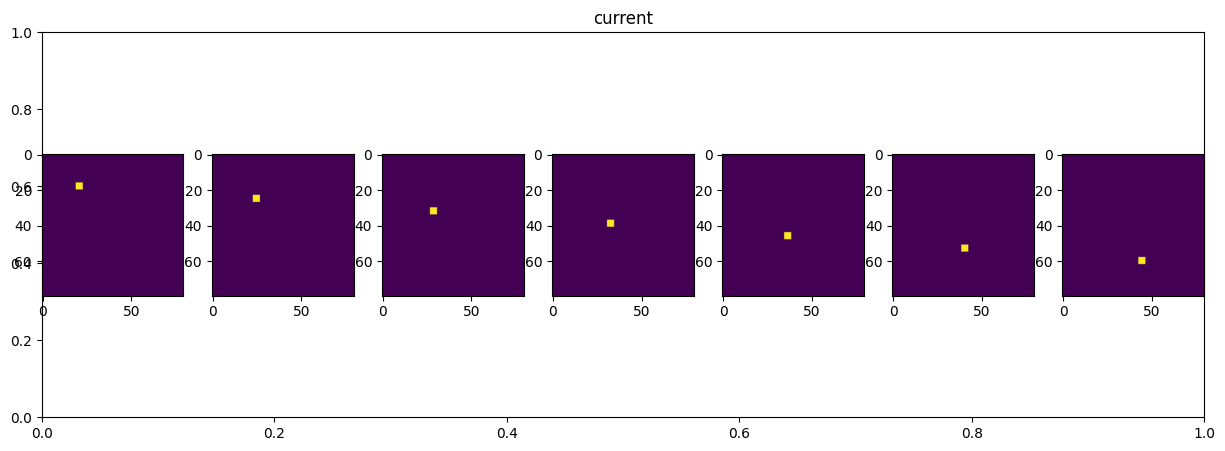

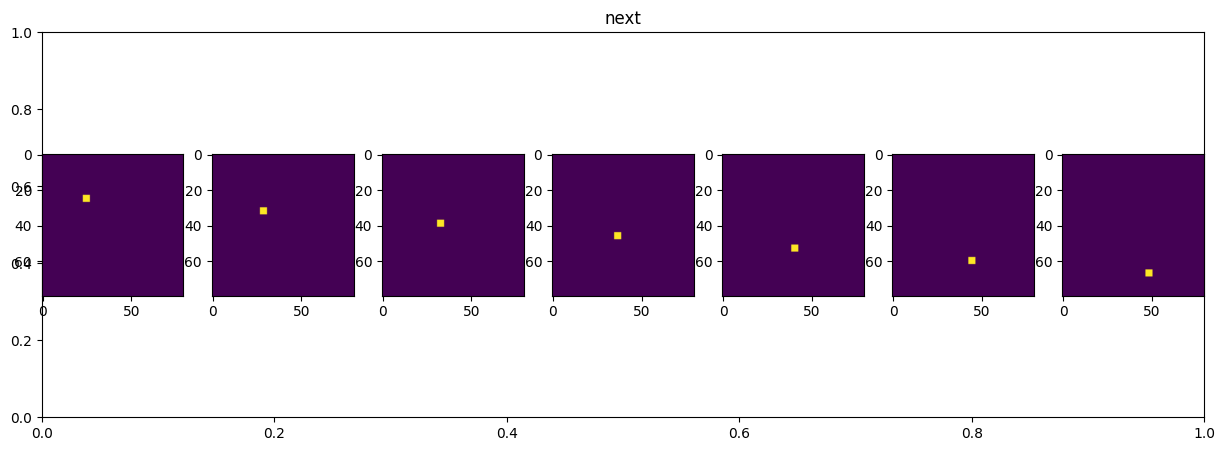

In [9]:
video1,video2 = gen_video(8)
plt.figure(figsize=(15,5))
plt.title("current")
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(video1[i])
plt.figure(figsize=(15,5))
plt.title("next")
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(video2[i])

In [10]:
movies=[]
movies_truth=[]
for m in range(1000):
    movie, movie_t = gen_video(15)
    movies.append(movie)
    movies_truth.append(movie_t)
movies = np.array(movies)
movies_truth = np.array(movies_truth)
movies.shape,movies_truth.shape

((1000, 15, 80, 80, 1), (1000, 15, 80, 80, 1))

In [17]:
seq = Sequential()
input = Input(shape=(None,80,80,1))

cl1 =ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   #input_shape=(None, 80, 80, 1),
                   padding='same', return_sequences=True)(input)
b1 = BatchNormalization()(cl1)

cl2 = ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True)(b1)
b2 = BatchNormalization()(cl2)

cl3 = ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True)(b2)
b3 = BatchNormalization()(cl3)

cl4 = ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True)(b3)
b4 = BatchNormalization()(cl4)

out = Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last')(b4)
model = Model(inputs=input,outputs = out)
model.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=['accuracy'])

In [1]:
model.summary()

NameError: name 'model' is not defined

In [19]:
model.fit(movies[:900],movies_truth[:900],batch_size=10,epochs=5, validation_split=0.1)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5862 - loss: 0.7777 - val_accuracy: 0.9219 - val_loss: 0.6726
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6928 - loss: 0.7276 - val_accuracy: 0.7967 - val_loss: 0.6706
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6846 - loss: 0.6918 - val_accuracy: 0.6579 - val_loss: 0.6859
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6864 - loss: 0.6621 - val_accuracy: 0.6664 - val_loss: 0.6644
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7096 - loss: 0.6370 - val_accuracy: 0.8209 - val_loss: 0.5852


In [20]:
#1st 7 frames
track = movies[955][:7]
#track[np.newaxis, ::, ::, ::, ::].shape


In [16]:
track.shape

(7, 80, 80, 1)

In [21]:
new_pos = model.predict(track[np.newaxis, ::, ::, ::, ::])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [22]:
new_pos.shape

(1, 7, 80, 80, 1)

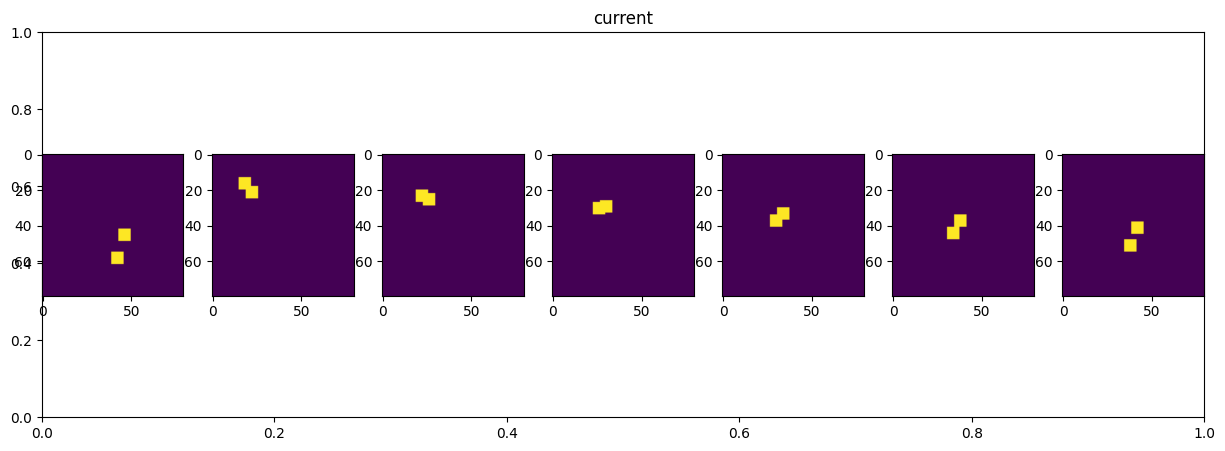

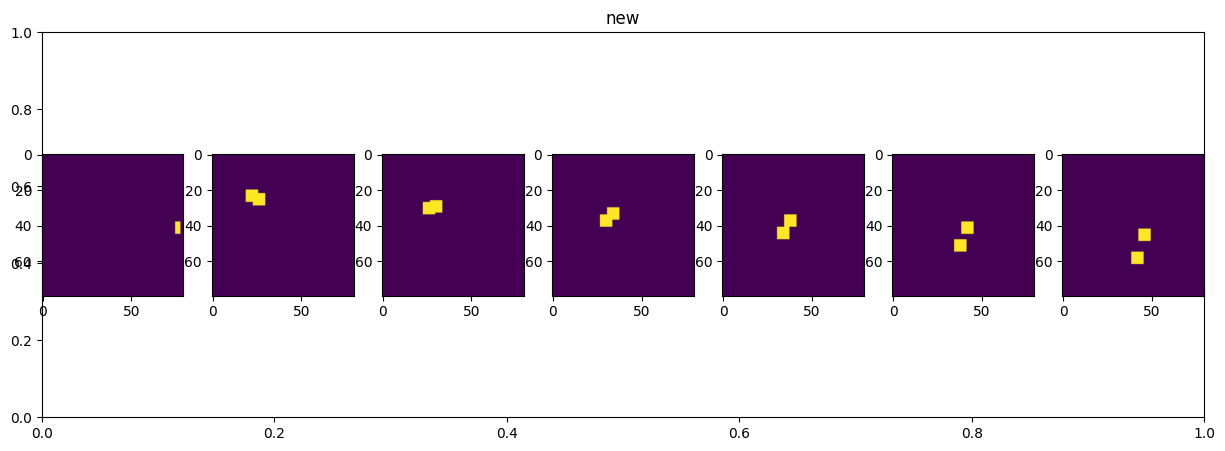

In [ ]:
plt.figure(figsize=(15,5))
plt.title("current")
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(track[i-1,:,:,0])
plt.figure(figsize=(15,5))
plt.title("new")
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(movies_truth[955,i-1,:,:,0])

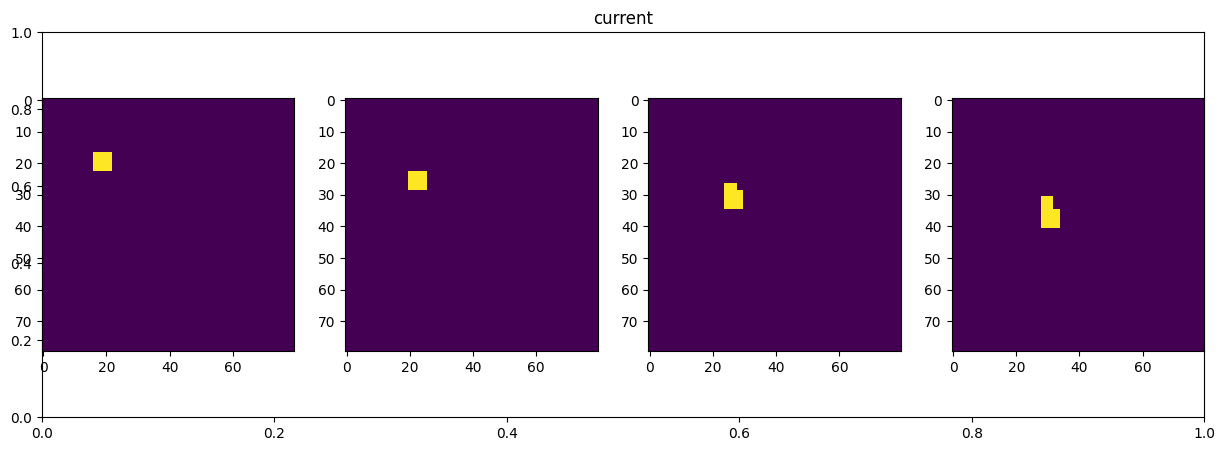

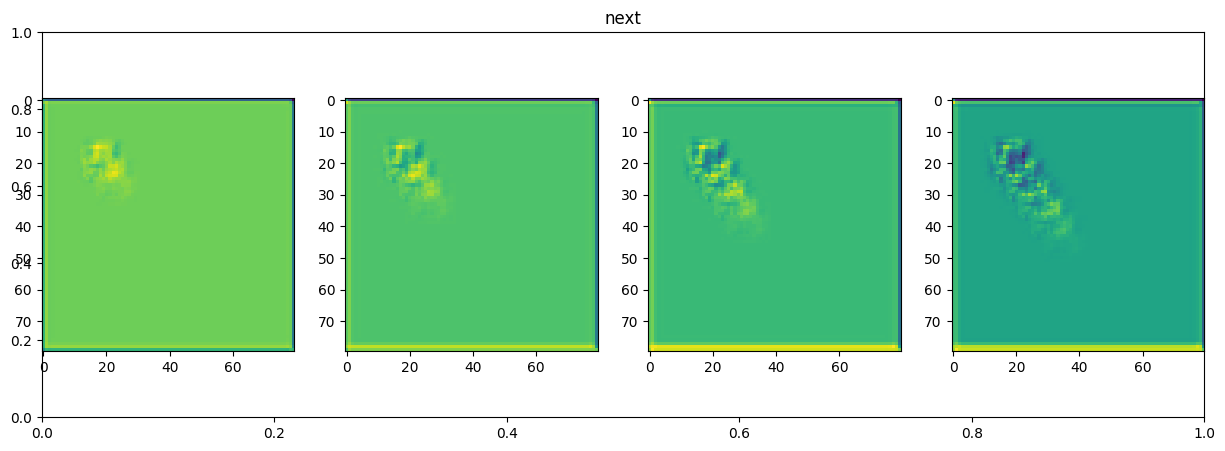

In [26]:

plt.figure(figsize=(15,5))
plt.title("current")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(track[i])
plt.figure(figsize=(15,5))
plt.title("next")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(new_pos[0,i,:,:,:])